In [1]:
# Configs
dataset_dir = r'C:\Users\fardin\Projects\EnhanceSEO\datasets\extractedURLs\url_classes.csv'

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, TweetTokenizer
import time
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(dataset_dir)
df.dropna(inplace=True)
class_list = df.Topic.unique()
class_id = {t:i for i, t in enumerate(class_list)}
id_class = {i:t for i, t in enumerate(class_list)}
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=True)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024
device

device(type='cuda')

In [6]:
urltokenizer = lambda url: list(urlparse(url))

In [7]:
chars = set([c for a in df.Address.values for c in ' '.join(urltokenizer(a))])
vocab_dict = {c:i for i, c in enumerate(chars)}

In [8]:
class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, y, num_classes, dictionary, tokenizer, doc_token_length=256, doc_char_length=1024) -> None:
        super().__init__()
        self.doc_char_length = doc_char_length
        self.doc_teken_length = doc_token_length
        
        
        y = torch.from_numpy(np.array([class_id[c] for c in y], dtype=np.longlong))
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        
        self.dictionary = dictionary
        self.dict_keys = list(dictionary.keys())
        self.vocab_size = len(self.dictionary)
        self.tokenizer = tokenizer
        
        self.X = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        # self.token_lengths = torch.zeros((len(X), self.doc_teken_length), dtype=torch.int)
        self.token_indices = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        
        for i, doc in enumerate(X):
            tokens = self.tokenizer(doc)
            tokens.append(self.dict_keys[-1])
            doc = ' '.join(tokens)
            
            indices = torch.from_numpy(np.array([self.dictionary[t] for t in doc if t in self.dictionary], dtype=np.longlong))
            char_pad_size = max(self.doc_char_length - len(indices), 0)
            
            self.X[i] = torch.nn.functional.pad(indices[:self.doc_char_length], (0,char_pad_size))
            
            token_lengths = torch.from_numpy(np.array([len(t) for t in tokens], dtype=np.longlong))+1
            token_lengths[-1] -= 1
            token_indices = torch.repeat_interleave(torch.arange(len(token_lengths), dtype=torch.long), token_lengths)
            token_indices = torch.nn.functional.pad(token_indices[:self.doc_char_length], (0,char_pad_size), value=len(token_lengths)-1)
            self.token_indices[i] = token_indices
        
        
    def __getitem__(self, index):
        return self.X[index], self.y[index], self.token_indices[index]
        
    def __len__(self):
        return len(self.y)
        

In [9]:
train_dataset = CharacterandTokenLevelCustomDataset(df_train.Address.values, df_train.Topic.values, len(class_id), vocab_dict, urltokenizer, doc_token_length=64, doc_char_length=256)
test_dataset = CharacterandTokenLevelCustomDataset(df_test.Address.values, df_test.Topic.values, len(class_id), vocab_dict, urltokenizer, doc_token_length=64, doc_char_length=256)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

In [12]:
token_lens = []
char_lens = []
dict_keys = list(vocab_dict.keys())
for doc in df.Address.values:
    tokens = urltokenizer(doc)
    tokens.append(dict_keys[-1])
    doc = ' '.join(tokens)
    token_lens.append(len(tokens))
    char_lens.append(len(doc))

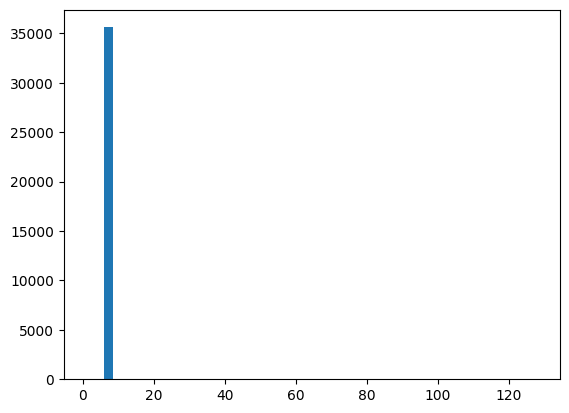

In [13]:
char_lens = np.array(char_lens)
plt.hist(token_lens, bins=50, range=(1, 128))
plt.show()

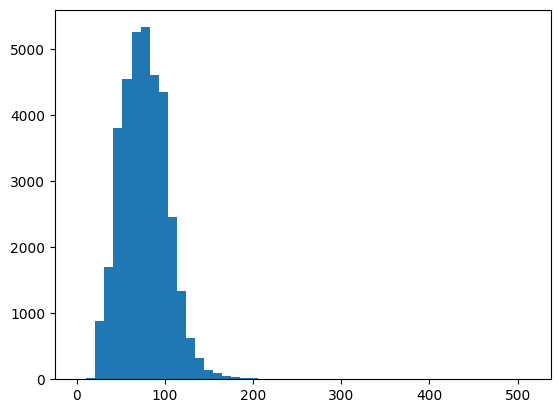

In [14]:
char_lens = np.array(char_lens)
plt.hist(char_lens, bins=50, range=(1, 512))
plt.show()

In [15]:
from torch_scatter import scatter_max, scatter_mean

In [16]:
st = time.time()
X, y, tc = next(iter(test_dataloader))
print(f'dataset time = {time.time() - st}')

dataset time = 0.045037269592285156


In [17]:
torch.max(X[1][0:9])

tensor(46)

In [18]:
tc[1][0:20]

tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
scatter_max(X,tc, dim=1)[0]

tensor([[46, 75, 89,  ..., 15, 15, 94],
        [46, 72, 87,  ..., 15, 15, 94],
        [46, 76, 87,  ..., 15, 15, 94],
        ...,
        [46, 76, 81,  ..., 15, 15, 94],
        [46, 76, 81,  ..., 15, 15, 94],
        [46, 76, 81,  ..., 77, 15, 94]])

In [20]:
class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, batch_size, max_char_count, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.max_char_count = max_char_count
        if seed>-1:
            torch.manual_seed(seed)
        
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        # nn.init.normal_(self.embedding.weight)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        
        # self.conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        self.globalpool = nn.AdaptiveMaxPool1d(hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * hidden_dim, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
    
    def forward(self, x, token_counts):
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        # x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x1 = scatter_max(x,token_counts, dim=1)[0]
        x2 = scatter_mean(x,token_counts, dim=1)
        # x2 = scatter_sum(x,token_counts, dim=1)
        # x2 = scatter_std(x,token_counts, dim=1)
        x = torch.cat([x1, x2], dim=2)
        # x = F.layer_norm(x, (x.shape[1], x.shape[2]))
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        x = self.globalpool(x)
        x = F.elu_(self.fc1(x.view(x.shape[0], -1)))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [21]:
model = CNN_for_Text(num_embedding=len(vocab_dict), batch_size=batch_size, max_char_count=256, embedding_dim=96, num_out_features=len(class_id))

In [22]:
model(X, tc)

tensor([[ 0.1791,  0.0382,  0.1253,  ..., -0.1396,  0.0562,  0.1016],
        [ 0.1671,  0.0265,  0.1696,  ..., -0.1153,  0.0687,  0.0953],
        [ 0.1539,  0.0123,  0.1814,  ..., -0.1369,  0.0651,  0.1026],
        ...,
        [ 0.1719,  0.0298,  0.1722,  ..., -0.1331,  0.0634,  0.0846],
        [ 0.1979,  0.0302,  0.1305,  ..., -0.1544,  0.0558,  0.1071],
        [ 0.1859,  0.0341,  0.0845,  ..., -0.1654,  0.0305,  0.1010]],
       grad_fn=<AddmmBackward0>)

In [23]:
import torchmetrics
import lightning as L
# from abc import abstractmethod

In [24]:

class ClassifierLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(ClassifierLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters("model", logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, token_count, *args, **kwargs):
        return self.model(x, token_count)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y, token_count = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X, token_count)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y, token_count = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X, token_count)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [25]:

lr= 0.0039
# 0.00010631317724117211
output_size = 128

In [26]:
hidden_dim = 256
embedding_dim = 128
label_size = 1

classifier_torch_model = CNN_for_Text(num_embedding=len(vocab_dict), batch_size=batch_size, max_char_count=256, dropout=0.2, num_out_features=len(class_id)).to(device)
optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=0.00012)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=True)
loss_func = torch.nn.BCEWithLogitsLoss()
classfier_lightning_model = ClassifierLightningModel(classifier_torch_model, 
                                                     num_classes=len(class_id),
                                            learning_rate=lr,
                                            batch_size=batch_size,
                                            optimizer=optimizer,
                                            loss_func=loss_func,
                                            lr_scheduler=lr_scheduler,
                                            user_lr_scheduler=True
                                            ).to(device)

Adjusting learning rate of group 0 to 3.9000e-03.


C:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [27]:
# from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import lightning as L

# from scripts.utils.CustomCallbacks.ModelCheckpoint import CustomModelCheckpoint

# callbacks = [
#         CustomModelCheckpoint(dirpath=r'models\model2_word_embedding-256-2', filename='str_embedding', every_n_epochs=1, mode='min', monitor='train_loss', save_on_train_epoch_end=True),
#         ModelCheckpoint(save_top_k=5, mode='min', monitor='train_loss', save_last=True)
#         ]
trainer = L.Trainer(
            # callbacks=callbacks,
            max_epochs=400,
            accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
            logger=CSVLogger(save_dir='logs/', name='log2'), 
            num_sanity_val_steps=0,
        #     default_root_dir='models\model2_word_embedding-256-2'
        )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
# from lightning.pytorch.tuner import Tuner
# tuner = Tuner(trainer)
# tuning_result = tuner.lr_find(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader, min_lr=0.00001,max_lr=0.1, num_training=1000)

# fig = tuning_result.plot(suggest=True)
# fig.show()

In [29]:
max_epochs = 1000
trainer.fit_loop.max_epochs = max_epochs
trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CNN_for_Text       | 215 K 
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
C:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer

Training: |                                                                                      | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.9000e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.9500e-03.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 9.7500e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 4.8750e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 2.4375e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 1.2187e-04.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 6.0937e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

Adjusting learning rate of group 0 to 3.0469e-05.


Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [31]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix

def calculate_metrics(cl_model):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y, tc in tqdm(test_dataloader):
        X = X.to(device)
        tc = tc.to(device)
        with torch.no_grad():
            y_p = cl_model(X, tc)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [32]:
classfier_lightning_model.model = classfier_lightning_model.model.eval()
classfier_lightning_model = classfier_lightning_model.eval()
calculate_metrics(classfier_lightning_model)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 13.45it/s]

classification report: 
               precision    recall  f1-score   support

           0     0.7617    0.7563    0.7590       279
           1     0.8139    0.8920    0.8511       250
           2     0.9238    0.7803    0.8460       264
           3     0.8111    0.8202    0.8156       267
           4     0.6610    0.6890    0.6747       283
           5     0.7022    0.7520    0.7262       254
           6     0.7034    0.6777    0.6903       273
           7     0.8692    0.8278    0.8480       273
           8     0.8066    0.6333    0.7095       270
           9     0.6294    0.8140    0.7099       242
          10     0.8139    0.7490    0.7801       251
          11     0.7912    0.8675    0.8276       166

    accuracy                         0.7669      3072
   macro avg     0.7740    0.7716    0.7699      3072
weighted avg     0.7737    0.7669    0.7674      3072

confusion matrix:
 tensor([[211,   7,   5,   1,   7,   4,   7,   1,  22,   8,   1,   5],
        [  2, 223, 